We fetched COVID-19 historical data for Italy and France, loaded it into JSON dataframes and converted it to pandas dataframes. 

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, AutoDateLocator


url_fr = "https://disease.sh/v3/covid-19/historical/France?lastdays=all"
url_it = "https://disease.sh/v3/covid-19/historical/Italy?lastdays=all"

resp_fr = requests.get(url_fr)
resp_it = requests.get(url_it)

resp_fr.raise_for_status()
resp_it.raise_for_status()

data_fr_js = resp_fr.json()
data_it_js = resp_it.json()

data_it = pd.DataFrame(data_it_js["timeline"])
data_fr = pd.DataFrame(data_fr_js["timeline"])


In [3]:
print(data_fr.isnull().values.any()) 
print(data_it.isnull().values.any()) 

False
False


In [4]:
print(data_it.index.duplicated().sum())
print(data_fr.index.duplicated().sum())
#stampa il numero di volte in cui una data è ripetuta

0
0


By performing a general analysis of the dataset using the describe command, we encountered an issue. Specifically, for the "recovered" variable in both France and Italy, the median is significantly different from the mean. In particular, the value of zero for a cumulative variable—such as the number of recovered individuals—does not make logical sense. Further investigation of the dataset revealed the presence of null values. After 08/05/2021, the recovered data for both countries consist only of zeros.

In [6]:
print(data_it.describe()) 
print(data_fr.describe())

              cases         deaths     recovered
count  1.143000e+03    1143.000000  1.143000e+03
mean   8.821664e+06  111930.694663  6.642502e+05
std    9.064593e+06   59672.484414  1.257262e+06
min    0.000000e+00       0.000000  0.000000e+00
25%    7.457085e+05   39235.500000  0.000000e+00
50%    4.440669e+06  128432.000000  0.000000e+00
75%    1.736443e+07  166509.000000  2.606320e+05
max    2.560351e+07  188322.000000  4.144608e+06
              cases         deaths      recovered
count  1.143000e+03    1143.000000    1143.000000
mean   1.409091e+07   99221.659668   84432.664917
std    1.470445e+07   53297.832483  128282.286212
min    0.000000e+00       0.000000       0.000000
25%    1.579906e+06   38108.500000       0.000000
50%    6.543481e+06  112925.000000       0.000000
75%    2.964361e+07  149168.000000  113149.000000
max    3.986672e+07  166176.000000  415111.000000


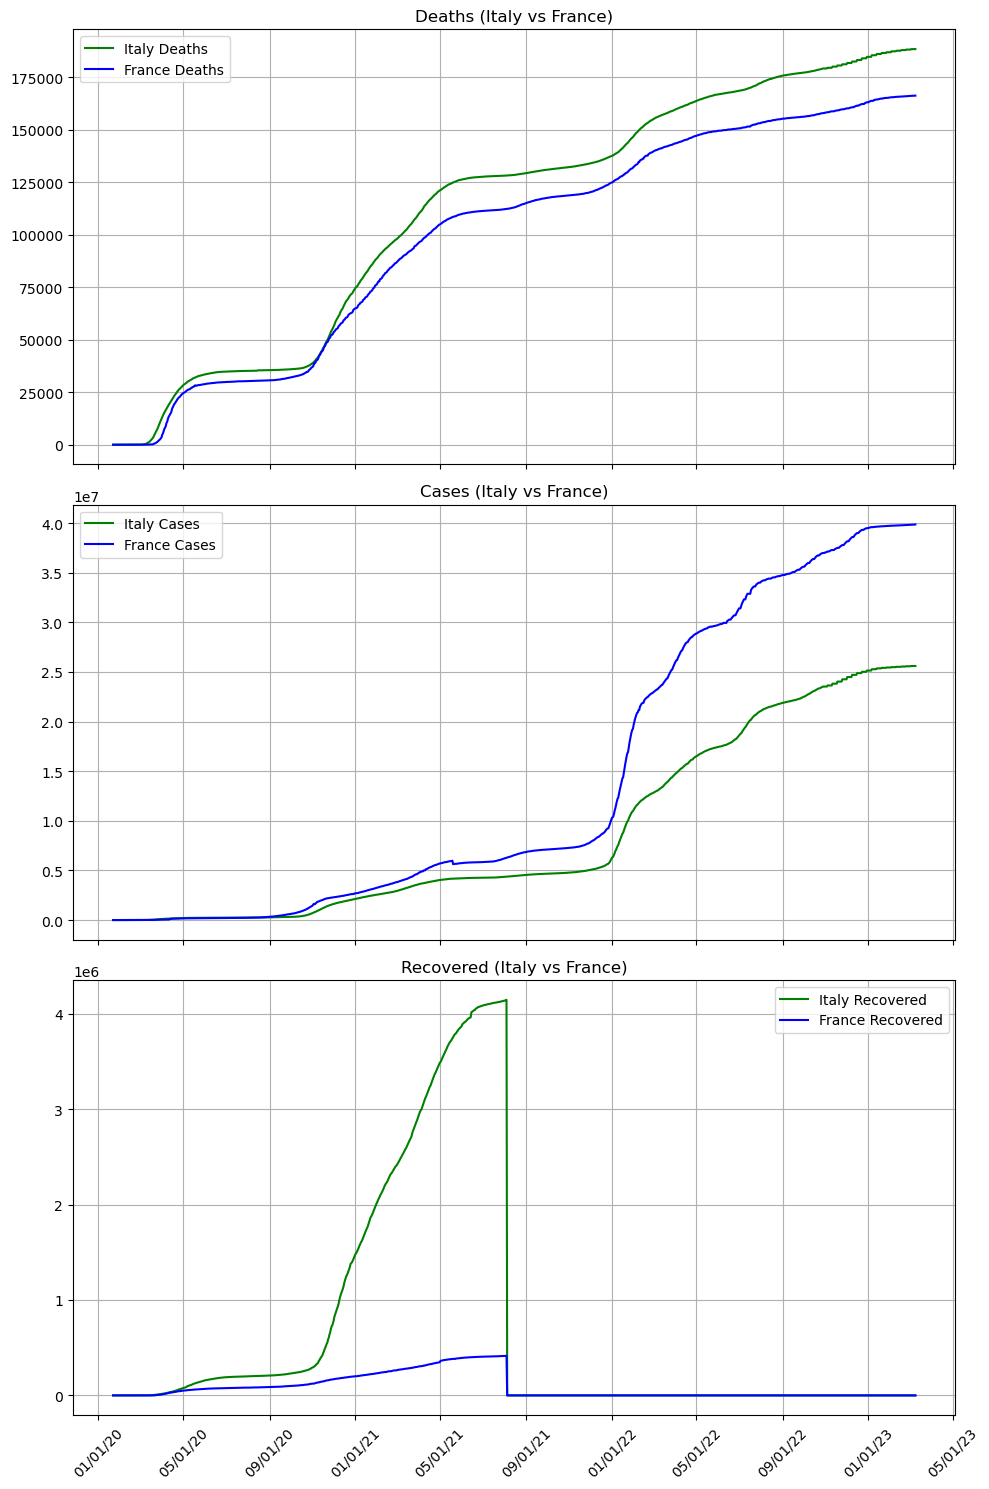

In [7]:
data_fr.index = pd.to_datetime(data_fr.index, format="%m/%d/%y")
data_it.index = pd.to_datetime(data_it.index, format="%m/%d/%y")

# Creare il grafico per i dati di Italia e Francia
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Formattazione dell'asse x
date_locator = AutoDateLocator()
date_formatter = DateFormatter("%m/%d/%y")

# Dati di decessi (Italia vs Francia)
axes[0].plot(data_it.index, data_it["deaths"], label="Italy Deaths", color="green")
axes[0].plot(data_fr.index, data_fr["deaths"], label="France Deaths", color="blue")
axes[0].set_title("Deaths (Italy vs France)")
axes[0].legend()

# Dati di casi (Italia vs Francia)
axes[1].plot(data_it.index, data_it["cases"], label="Italy Cases", color="green")
axes[1].plot(data_fr.index, data_fr["cases"], label="France Cases", color="blue")
axes[1].set_title("Cases (Italy vs France)")
axes[1].legend()

# Dati di guarigioni (Italia vs Francia)
axes[2].plot(data_it.index, data_it["recovered"], label="Italy Recovered", color="green")
axes[2].plot(data_fr.index, data_fr["recovered"], label="France Recovered", color="blue")
axes[2].set_title("Recovered (Italy vs France)")
axes[2].legend()

# Configurare l'asse x per tutti i subplot
for ax in axes:
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)
    ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

We can see that the number of recovered, both in Italy and France, suddenly drops to zero around August 2021 and remains zero thereafter. We will have to handle this.
Moreover, another particular feature can be observed, except for the sudden drop in recovered, all the graphs seem to be increasing, so it is fair to assume that the data is cumulative.
NdT: we actually looked online for graphs of cumulative cases, deaths, recovered, and they are very similar to the ones we are working with (Disease.shdocs)

In [9]:
zero_recovered_it = data_it[(data_it["recovered"] == 0) & (data_it.index > "31-05-2021")].index.min()
zero_recovered_fr = data_fr[(data_it["recovered"] == 0) & (data_fr.index > "31-05-2021")].index.min()

print(zero_recovered_it)
print(zero_recovered_fr)

2021-08-05 00:00:00
2021-08-05 00:00:00


We start the data cleaning process by eliminating all the zero-valued data in the recovered for bouth dataset from summer 2021.

In [11]:
cutoff_date = "7/5/21"
data_fr_cut = data_fr[data_fr.index <= cutoff_date]
data_it_cut = data_it[data_it.index <= cutoff_date]

We continue by checking the consistency of the data, in particular, we must:
- Check that there are no missing or duplicated values
- Check that the data is actually cumulative, i.e. they are non-decreasing
- Check that the the cumulative data is consistent, i.e. the number of deaths and the number of recovered cannot be greater than the number of cases

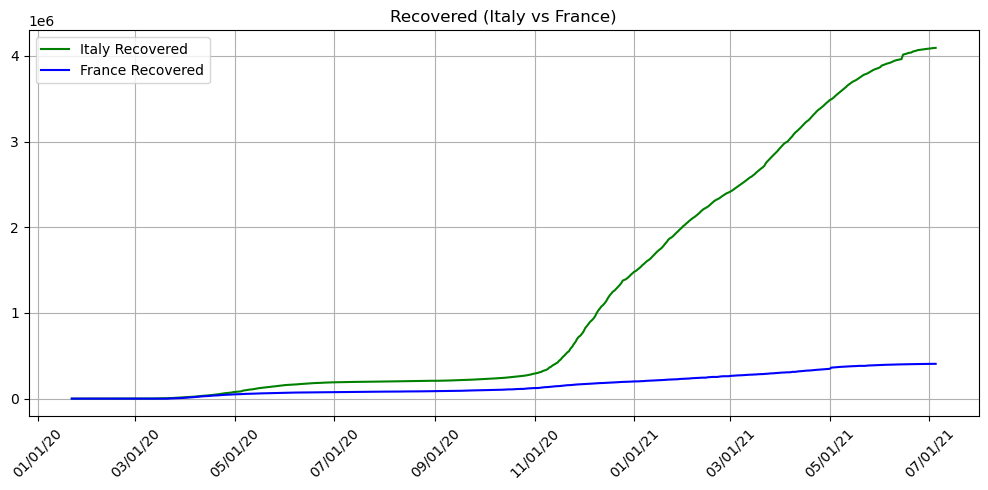

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data_it_cut.index, data_it_cut["recovered"], label="Italy Recovered", color="green")
ax.plot(data_fr_cut.index, data_fr_cut["recovered"], label="France Recovered", color="blue")
ax.set_title("Recovered (Italy vs France)")
ax.legend()

# Configurare l'asse x
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

The three variables used above are cumulative. We use the `.diff` command to observe the daily trend of the values.

In [15]:
anomalous_days_it = data_it[data_it["deaths"] > data_it["cases"]]
print(anomalous_days_it[["deaths", "cases"]])
anomalous_days_fr = data_fr[data_fr["deaths"] > data_fr["cases"]]
print(anomalous_days_fr[["deaths", "cases"]])

Empty DataFrame
Columns: [deaths, cases]
Index: []
Empty DataFrame
Columns: [deaths, cases]
Index: []


In [16]:
anomalous_days_it = data_it[data_it["recovered"] > data_it["cases"]]
print(anomalous_days_it[["recovered", "cases"]])
anomalous_days_fr = data_fr[data_fr["recovered"] > data_fr["cases"]]
print(anomalous_days_fr[["recovered", "cases"]])

Empty DataFrame
Columns: [recovered, cases]
Index: []
Empty DataFrame
Columns: [recovered, cases]
Index: []


In [17]:
# here substitute recovered data only before 
#here we go through each observation for each data set 
def substitute_missing(df, column_name):
    dates_errors = []
    for i in range(1, len(df)):
        if df.loc[df.index[i], column_name] < df.loc[df.index[i-1], column_name]:
            df.loc[df.index[i], column_name] = df.loc[df.index[i-1], column_name]
            dates_errors.append(df.index[i])
    return df[column_name] , dates_errors


data_it.loc[: ,"cases"], mistakes_cases_it  = substitute_missing(data_it, "cases")
data_it.loc[:, "deaths"], mistakes_death_it  = substitute_missing(data_it, "deaths")
data_it_cut.loc[:,"recovered"], mistakes_recovered_it  = substitute_missing(data_it_cut.copy(), "recovered")

data_fr.loc[:,"cases"], mistakes_cases_fr  = substitute_missing(data_fr, "cases")
data_fr.loc[:, "deaths"], mistakes_death_fr  = substitute_missing(data_fr, "deaths") 
data_fr_cut.loc[:,"recovered"], mistakes_recovered_fr =  substitute_missing(data_fr_cut.copy(), "recovered")
len(mistakes_cases_it) + len(mistakes_death_it)+ len(mistakes_recovered_it) +len(mistakes_cases_fr) + len(mistakes_death_fr) + len(mistakes_recovered_fr)

107

We found that the are no missing nor duplicated data and that the numbers of deaths and the number of recovered is not greater than the number of cases at any time.
However, we found that the cumulative data isn't increasing for a small finite number of dates, which is inconsistent with the cumulative nature of the data. We fix such mistake by substituing the number of cases, deaths or recovered of the ith day with the (i-1)th day . 

We can now start analyzing temporal trends. To do so, we plot daily and weekly results for deaths, recovered and cases, both in Italy and France.
Keep in mind that France population was 68 million in 2023, while Italy population was 58 million in 2023.

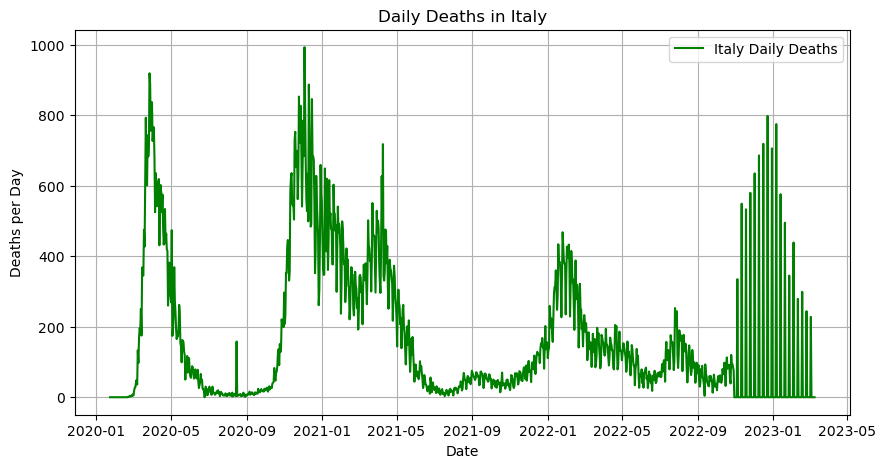

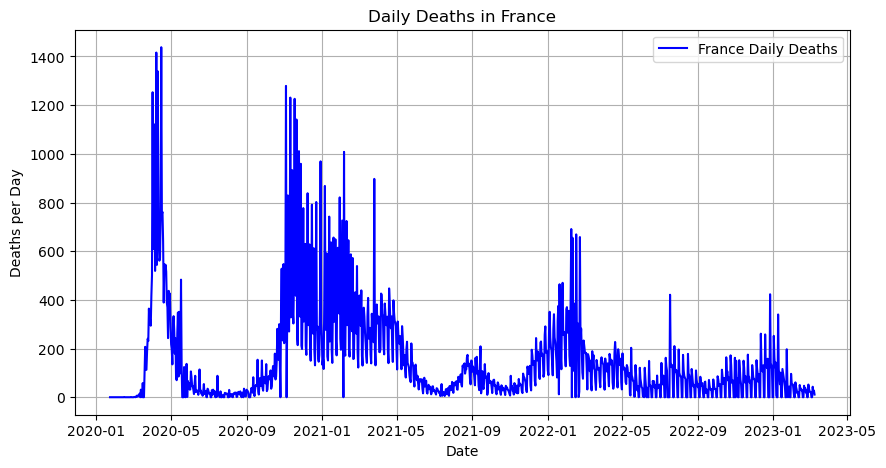

In [20]:
data_it["daily_deaths"] = data_it["deaths"].diff()
data_fr["daily_deaths"] = data_fr["deaths"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["daily_deaths"], label="Italy Daily Deaths", color="green")
plt.title("Daily Deaths in Italy")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["daily_deaths"], label="France Daily Deaths", color="blue")
plt.title("Daily Deaths in France")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

The jagged lines in our data are likely a result of our data cleaning process, which replaces erroneous values with those from the previous day. This approach is problematic because it causes daily case, death, and recovery counts to appear as zero, distorting the actual trends, to have a clearer picture of what is going on each time we will provide a smoothed curve that approximates better the trends present in our data.

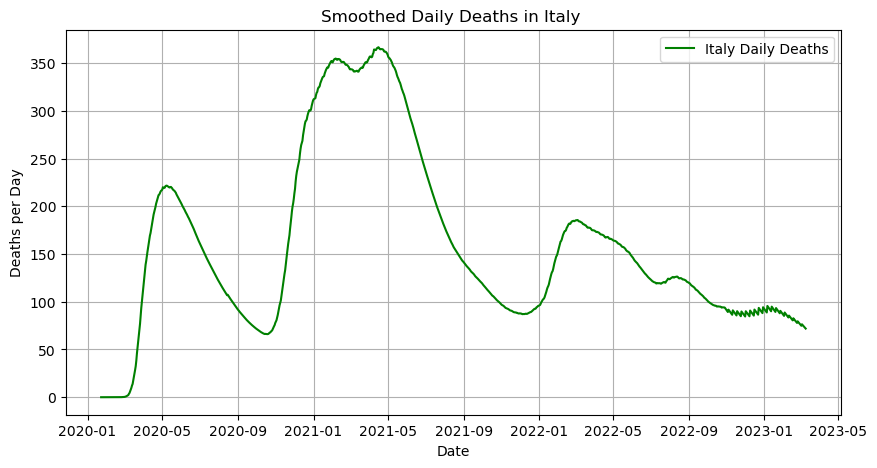

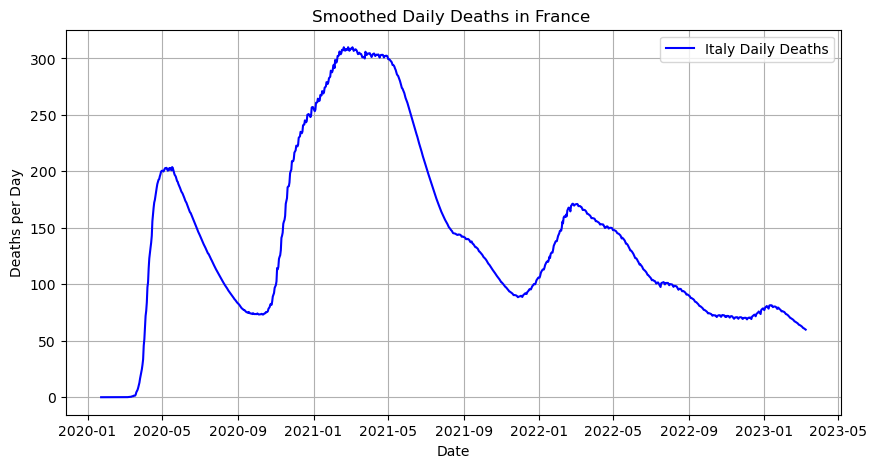

In [22]:
smoothed_data_it = data_it["daily_deaths"].ewm( alpha = 0.01 , adjust=False).mean()
smoothed_data_fr = data_fr["daily_deaths"].ewm( alpha = 0.01 , adjust=False).mean()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, smoothed_data_it, label="Italy Daily Deaths", color="green")
plt.title("Smoothed Daily Deaths in Italy ")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, smoothed_data_fr, label="Italy Daily Deaths", color="blue")
plt.title("Smoothed Daily Deaths in France ")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

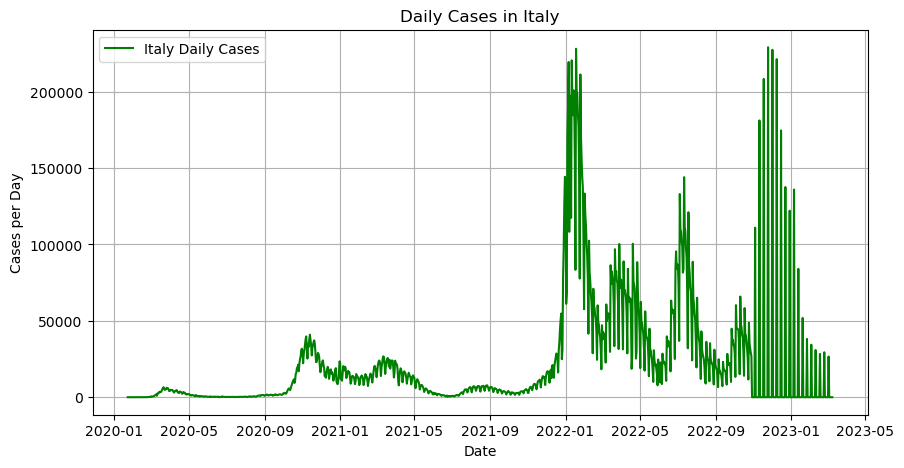

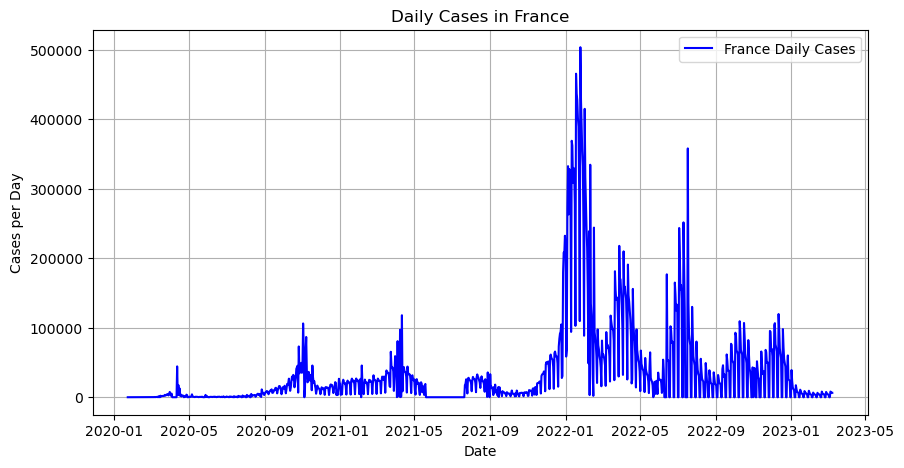

In [23]:
data_it["daily_cases"] = data_it["cases"].diff()
data_fr["daily_cases"] = data_fr["cases"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["daily_cases"], label="Italy Daily Cases", color="green")
plt.title("Daily Cases in Italy")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["daily_cases"], label="France Daily Cases", color="blue")
plt.title("Daily Cases in France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

For what concerns daily cases, we notice a similar behaviors of the curves of Italy and France, the peaks in daily cases happen in the same periods for the two countries. However, the magnitude of the peaks is very different: the maximum of daily cases in France (just above 500,000) is two times more than the one for Italy (which does not exceed 250,000). 


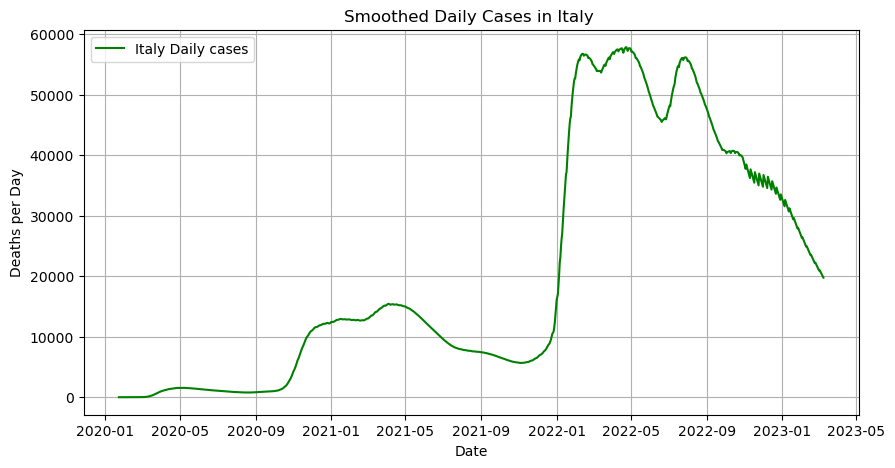

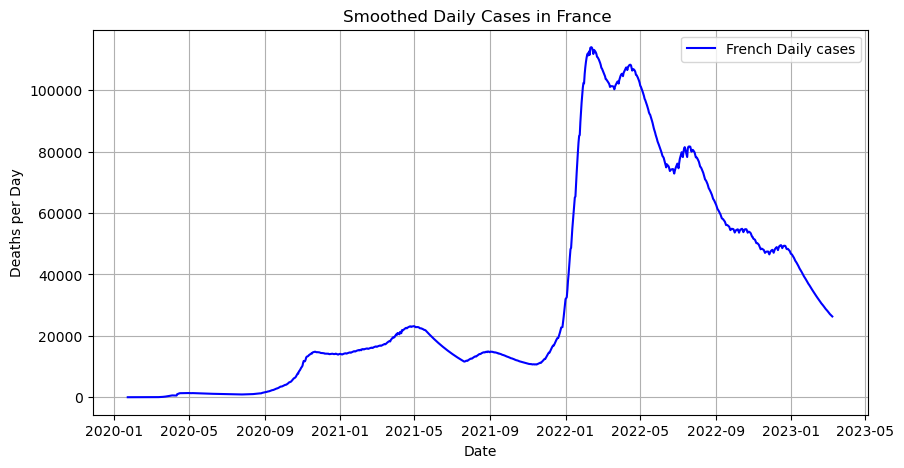

In [24]:
smoothed_data_it = data_it["daily_cases"].ewm( alpha = 0.01 , adjust=False).mean()
smoothed_data_fr = data_fr["daily_cases"].ewm( alpha = 0.01 , adjust=False).mean()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, smoothed_data_it, label="Italy Daily cases", color="green")
plt.title("Smoothed Daily Cases in Italy ")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, smoothed_data_fr, label="French Daily cases", color="blue")
plt.title("Smoothed Daily Cases in France ")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

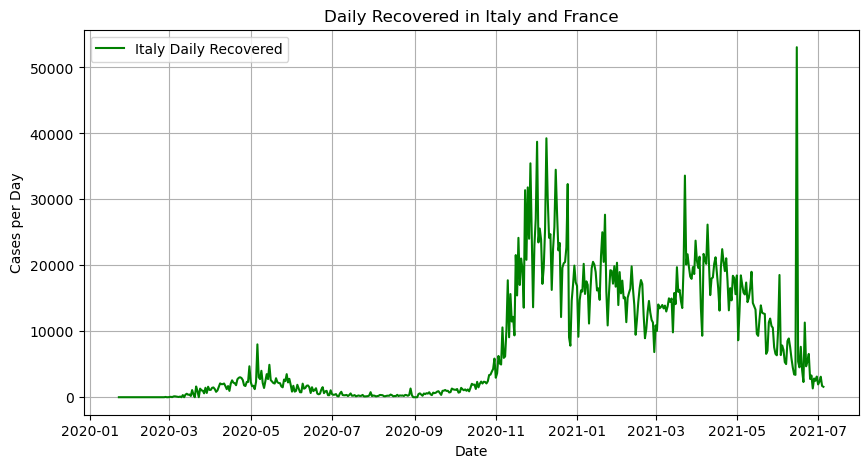

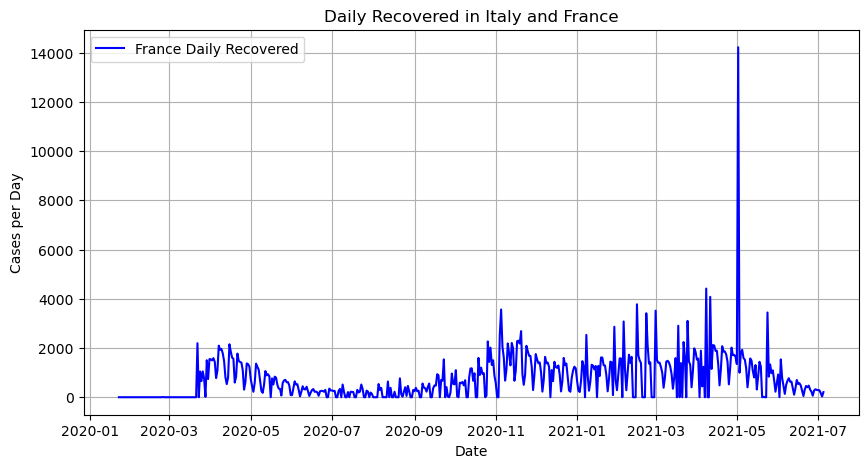

In [25]:
data_it_cut = data_it_cut.copy()
data_it_cut["daily_recovered"] = data_it_cut["recovered"].diff()
data_fr_cut = data_fr_cut.copy()
data_fr_cut["daily_recovered"] = data_fr_cut["recovered"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["daily_recovered"], label="Italy Daily Recovered", color="green")
plt.title("Daily Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr_cut.index, data_fr_cut["daily_recovered"], label="France Daily Recovered", color="blue")
plt.title("Daily Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

For what concerns daily deaths and daily recovered, we find again similar behaviors of the two curves, with France having again higher maximums.
However, for daily recovery, we can compare the two countries only until August 2021, date after which we do not have data for recovered. 

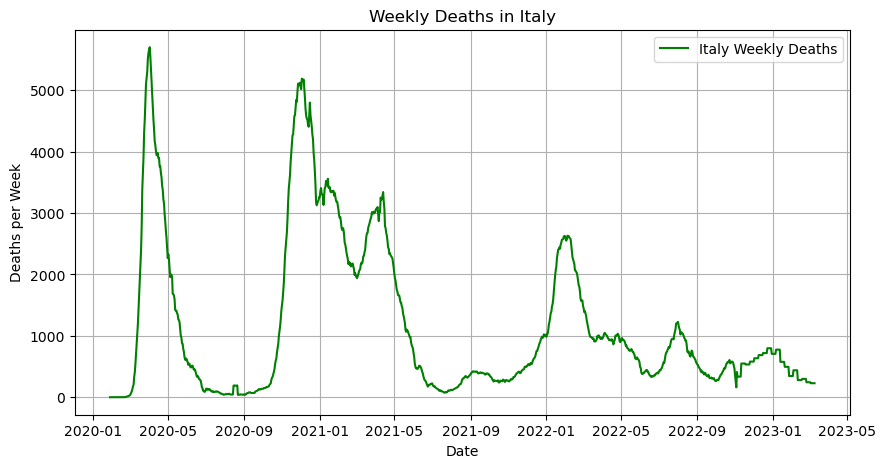

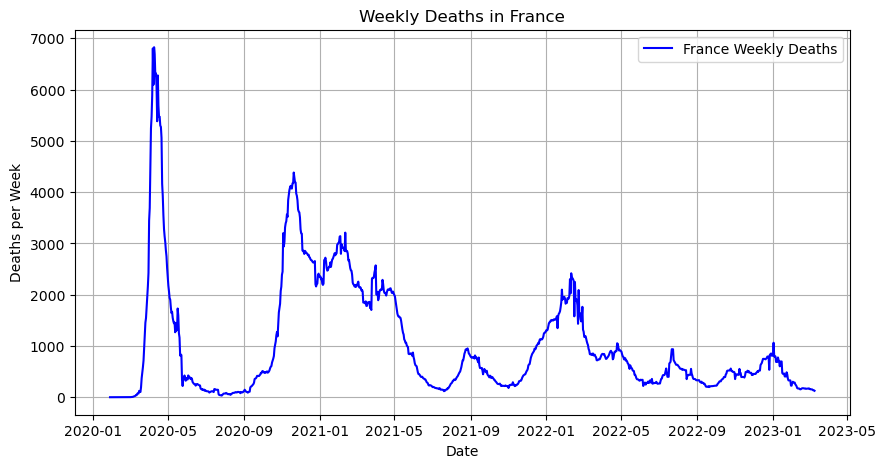

In [27]:
data_it = data_it.copy()
data_it.loc[:, "weekly_deaths"] = data_it["deaths"].diff(periods=7)
data_fr = data_fr.copy()
data_fr.loc[:, "weekly_deaths"] = data_fr["deaths"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["weekly_deaths"], label="Italy Weekly Deaths", color="green")
plt.title("Weekly Deaths in Italy")
plt.xlabel("Date")
plt.ylabel("Deaths per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["weekly_deaths"], label="France Weekly Deaths", color="blue")
plt.title("Weekly Deaths in France")
plt.xlabel("Date")
plt.ylabel("Deaths per Week")
plt.legend()
plt.grid()
plt.show()

Concerning weekly deaths, the curves show a similar pattern, both steeply increasing to their maximum around April 2020 and then sharply decreasing.

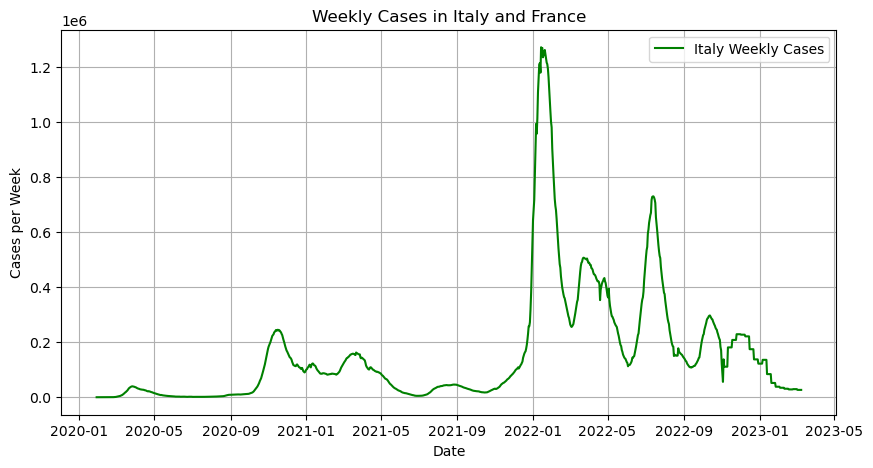

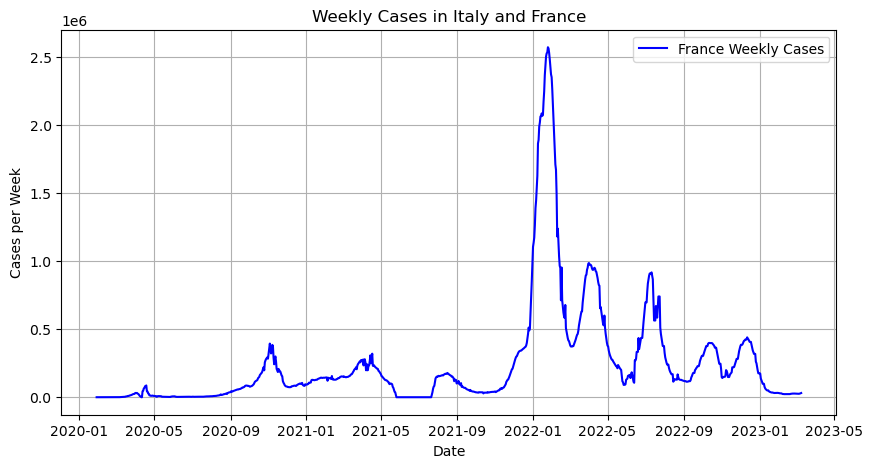

In [28]:
data_it["weekly_cases"] = data_it["cases"].diff(periods=7)
data_fr["weekly_cases"] = data_fr["cases"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["weekly_cases"], label="Italy Weekly Cases", color="green")
plt.title("Weekly Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["weekly_cases"], label="France Weekly Cases", color="blue")
plt.title("Weekly Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

Concerning weekly cases, both countries experienced a sudden increase around December 2021 and January 2022. However, the numbers of France are two times more than the ones of Italy.


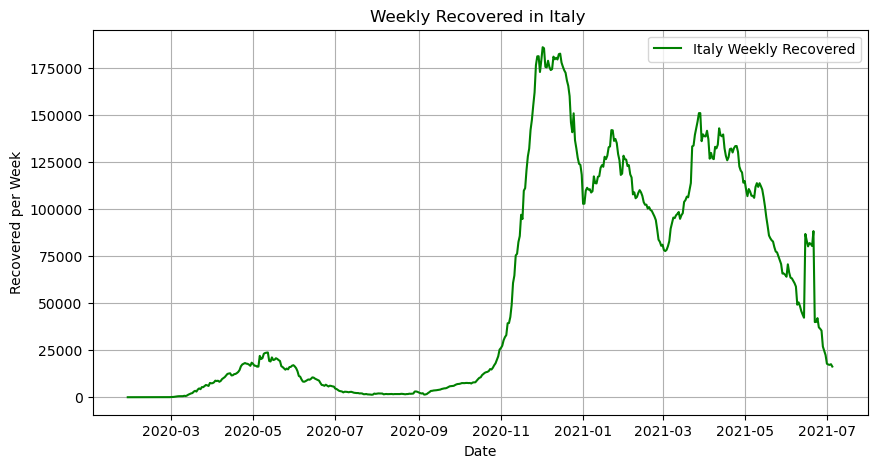

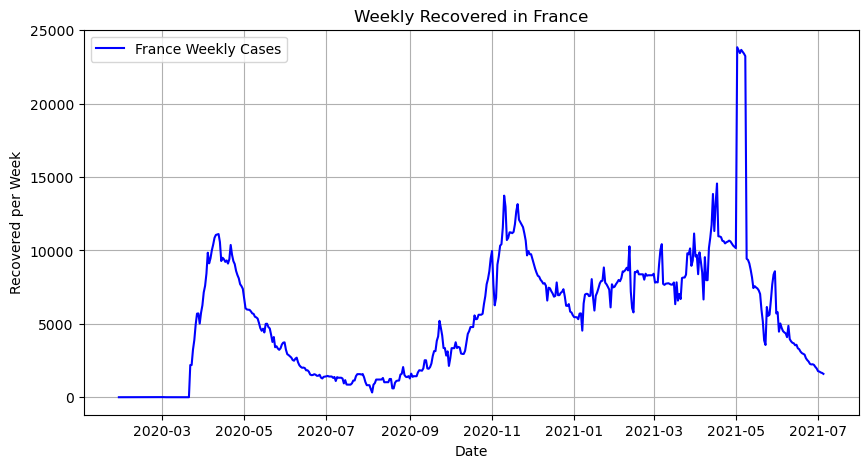

In [29]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["weekly_recovered"] = data_it_cut["recovered"].diff(periods=7)
data_fr_cut["weekly_recovered"] = data_fr_cut["recovered"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["weekly_recovered"], label="Italy Weekly Recovered", color="green")
plt.title("Weekly Recovered in Italy ")
plt.xlabel("Date")
plt.ylabel("Recovered per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr_cut.index, data_fr_cut["weekly_recovered"], label="France Weekly Cases", color="blue")
plt.title("Weekly Recovered in France")
plt.xlabel("Date")
plt.ylabel("Recovered per Week")
plt.legend()
plt.grid()
plt.show()

It can be observed that the graphs exhibit similar patterns. Special attention can be given to the "cases"-"recovered" ratio, as the latter represents the first shift by a few weeks. This can be explained by recalling that the time between becoming positive and recovering (returning to negative) typically takes a few weeks.


In general, the behaviors between France and Italy are comparable, except for the "recovered" variable.

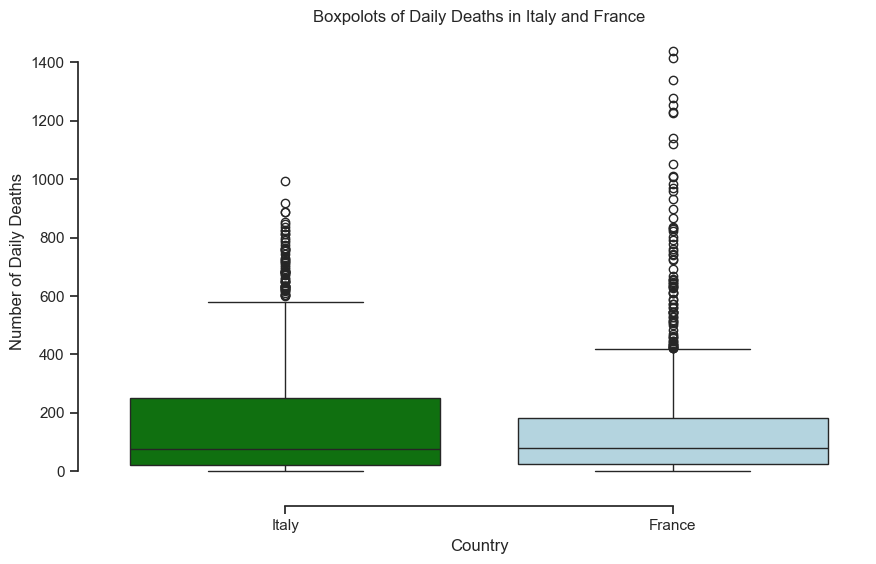

In [32]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "deaths": pd.concat([data_it["daily_deaths"], data_fr["daily_deaths"]], ignore_index=True),
    "country": ["Italy"] * len(data_it) + ["France"] * len(data_fr)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="deaths", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Deaths in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Deaths")

# Mostriamo il grafico
plt.show()

Boxplots for daily deaths and daily cases show many outliers, which is consistent with the fluctuations and the peaks of the analogous curves.


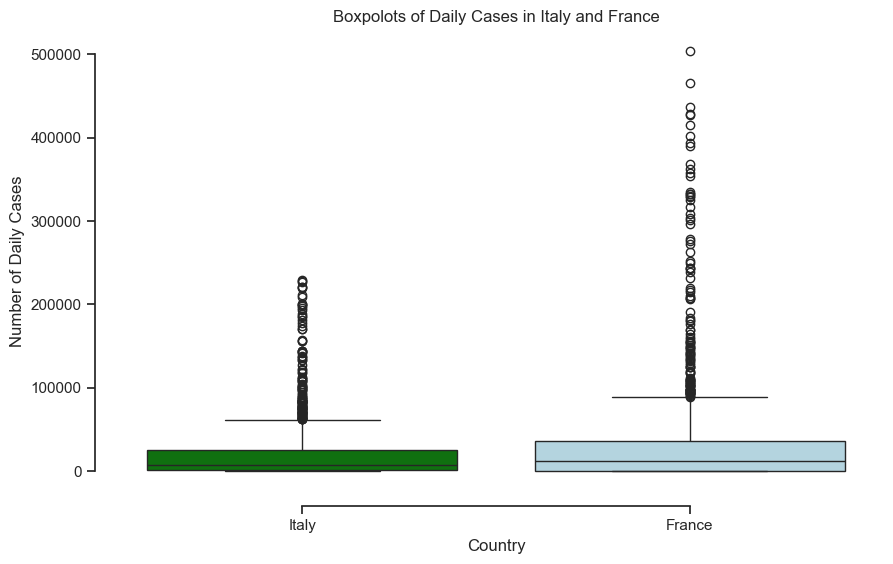

In [33]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "cases": pd.concat([data_it["daily_cases"], data_fr["daily_cases"]], ignore_index=True),
    "country": ["Italy"] * len(data_it) + ["France"] * len(data_fr)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="cases", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Cases in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Cases")

# Mostriamo il grafico
plt.show()

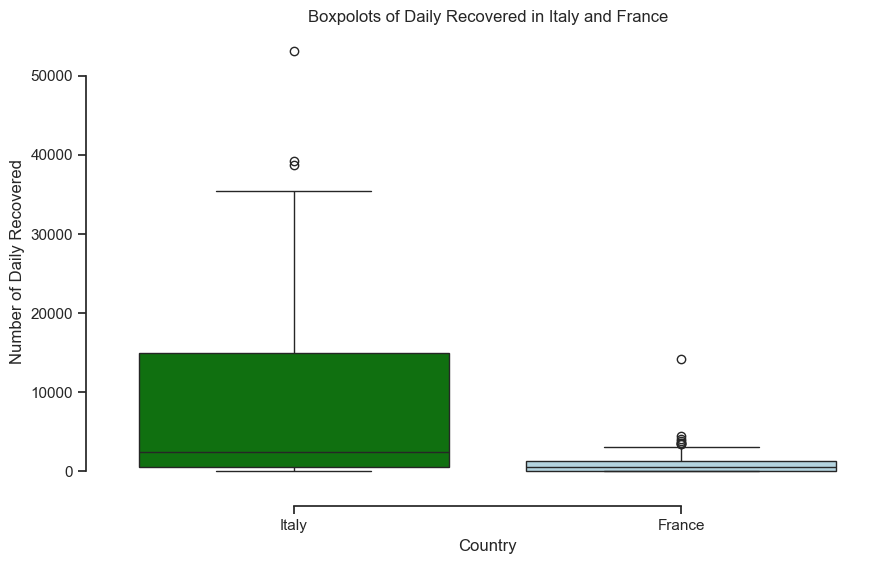

In [34]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "recovered": pd.concat([data_it_cut["daily_recovered"], data_fr_cut["daily_recovered"]], ignore_index=True),
    "country": ["Italy"] * len(data_it_cut) + ["France"] * len(data_fr_cut)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="recovered", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Recovered in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Recovered")

# Mostriamo il grafico
plt.show()

The boxplots for recovered show considerably less outliers and a low median, especially for Italy, which is consistent with its daily recovered curve, which attain higher values after November 2020.
Moreover, we notice that Italy’s interquartile range is much bigger than that of France, which is something that we expected given that Italy’s daily recovered curve has stronger fluctuations, especially after attaining its median value.
